# Task 5 – Feature Engineering

This notebook engineers demand and weather features, studies their distributions, and ranks the most
relevant predictors for the Home Energy Management System (HEMS) project. Figures and tables are
saved to `reports/figures/`, `reports/figures/interactive/`, and `reports/tables/` for inclusion in the
LaTeX report and dashboard.

## Setup

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import mutual_info_regression
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import display

plt.ioff()

ROOT = Path('..')
DATA_PATH = ROOT / 'data' / 'raw' / 'train_252145.csv'
FIGURES_DIR = ROOT / 'reports' / 'figures'
INTERACTIVE_DIR = FIGURES_DIR / 'interactive'
TABLES_DIR = ROOT / 'reports' / 'tables'
PROCESSED_PATH = ROOT / 'data' / 'processed'

for path in [FIGURES_DIR, INTERACTIVE_DIR, TABLES_DIR, PROCESSED_PATH]:
    path.mkdir(parents=True, exist_ok=True)

COLORS = {
    'demand': '#2ca02c',
    'temperature': '#F45B69',
    'irradiance': '#FFA500',
    'engineered': '#7f7f7f',
}

mpl.rcParams.update({
    'figure.dpi': 120,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.labelcolor': 'black',
    'axes.titleweight': 'semibold',
    'axes.titlelocation': 'left',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'grid.color': '#d9d9d9',
    'grid.linestyle': '--',
    'grid.linewidth': 0.6,
    'axes.grid': True,
    'font.family': 'DejaVu Sans',
    'legend.frameon': True,
    'legend.framealpha': 0.9,
    'legend.edgecolor': '#dddddd',
})

sns.set_theme(style='whitegrid')

px.defaults.template = 'plotly_white'
px.defaults.color_discrete_sequence = ['#2ca02c', '#F45B69', '#FFA500', '#1f77b4', '#7f7f7f']


def save_figure(fig, basename, dpi=300):
    png = FIGURES_DIR / f'{basename}.png'
    pdf = FIGURES_DIR / f'{basename}.pdf'
    fig.savefig(png, dpi=dpi, bbox_inches='tight')
    fig.savefig(pdf, dpi=dpi, bbox_inches='tight')
    return png, pdf


def save_interactive(fig, basename):
    html_path = INTERACTIVE_DIR / f'{basename}.html'
    fig.write_html(html_path, include_plotlyjs='cdn')
    return html_path

## Load dataset

In [2]:
# Load dataset
df = pd.read_csv(DATA_PATH, parse_dates=['timestamp']).sort_values('timestamp').set_index('timestamp')
weather_cols = [
    'Temperature', 'Pressure (hPa)', 'Cloud_cover (%)', 'Wind_speed_10m (km/h)',
    'Shortwave_radiation (W/m²)', 'direct_radiation (W/m²)',
    'diffuse_radiation (W/m²)', 'direct_normal_irradiance (W/m²)', 'Price'
]
subset = df[['Demand'] + weather_cols].copy()

print("Dataset Subset Head:")
display(subset.head())

Dataset Subset Head:


,Demand,Temperature,Pressure (hPa),Cloud_cover (%),Wind_speed_10m (km/h),Shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),Price
timestamp,,,,,,,,,,
2013-07-01 00:00:00+00:00,0.27,13.5,1011.3,4,10.5,NaN,0,0,0.0,0.01605
2013-07-01 01:00:00+00:00,0.23,13.2,1010.8,27,11.9,NaN,0,0,0.0,0.00095
2013-07-01 02:00:00+00:00,0.26,13.1,1010.3,33,11.6,NaN,0,0,0.0,0.00060
2013-07-01 03:00:00+00:00,0.28,13.0,1010.3,28,11.2,NaN,2,7,30.1,0.00046
2013-07-01 04:00:00+00:00,0.29,13.8,1010.2,16,11.7,NaN,30,31,252.0,0.00046


## Descriptive statistics

In [3]:
# Calculate descriptive statistics
stats_functions = ['mean', 'std', 'min', 'max']
summary = subset.agg(stats_functions).T
extra = subset.agg(['skew', 'kurtosis']).T
summary['skewness'] = extra['skew']
summary['kurtosis'] = extra['kurtosis']
summary = summary.round(3)
summary_path = TABLES_DIR / 'task5_descriptive_stats.csv'
summary.to_csv(summary_path)

print("Descriptive Statistics:")
display(summary)

Descriptive Statistics:


,mean,std,min,max,skewness,kurtosis
Demand,0.531,0.375,0.0,4.240,2.484,8.801
Temperature,7.515,8.312,-18.3,28.900,-0.209,-0.023
Pressure (hPa),1012.776,10.199,971.7,1041.000,-0.375,0.795
Cloud_cover (%),68.705,36.274,0.0,100.000,-0.778,-0.955
Wind_speed_10m (km/h),15.991,7.451,0.4,51.100,0.505,-0.044
Shortwave_radiation (W/m²),114.955,181.902,0.0,756.000,1.661,1.751
direct_radiation (W/m²),67.146,133.208,0.0,702.000,2.299,4.642
diffuse_radiation (W/m²),45.229,63.792,0.0,343.000,1.479,1.587
direct_normal_irradiance (W/m²),143.466,232.824,0.0,896.700,1.563,1.210
Price,0.046,0.025,0.0,0.255,1.200,5.481


### Figure 1 – Demand vs temperature

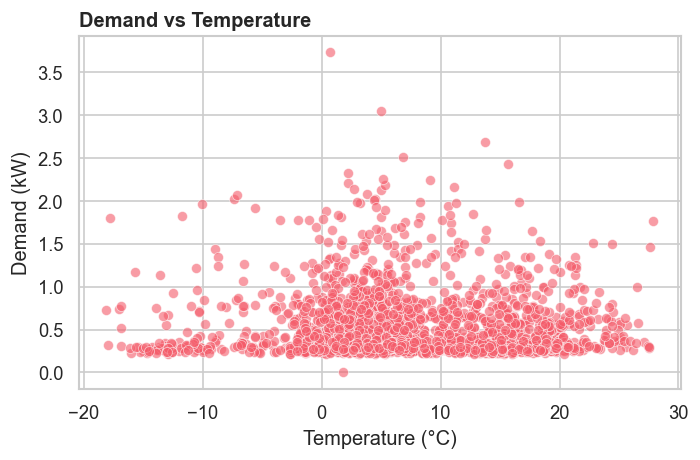

In [4]:
# Visualize Demand vs Temperature
sample_temp = subset.sample(2000, random_state=42)
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=sample_temp, x='Temperature', y='Demand', color=COLORS['temperature'], alpha=0.6, ax=ax)
ax.set_title('Demand vs Temperature')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Demand (kW)')
fig.tight_layout()
save_figure(fig, 'task5_fig_demand_vs_temperature')
plt.show() # Explicitly show the static plot

fig_px = px.scatter(sample_temp, x='Temperature', y='Demand', opacity=0.6,
                    labels={'Temperature': 'Temperature (°C)', 'Demand': 'Demand (kW)'},
                    title='Demand vs Temperature')
save_interactive(fig_px, 'task5_fig_demand_vs_temperature_interactive')
fig_px.show() # Explicitly show the interactive plot

### Figure 2 – Hourly demand profile

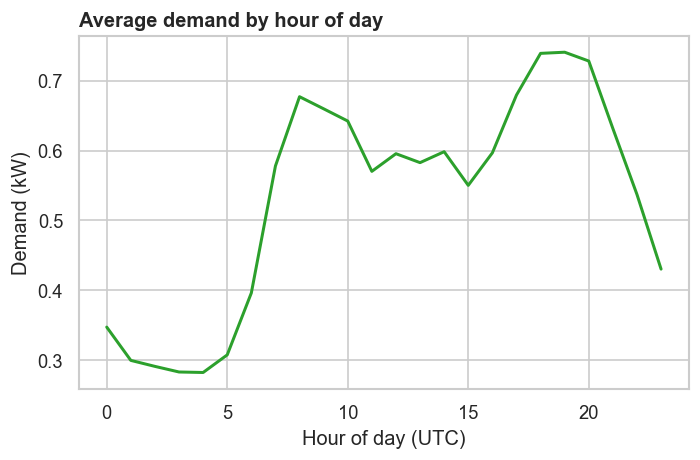

In [5]:
# Visualize Hourly Demand Profile
hour_profile = df['Demand'].groupby(df.index.hour).mean()
hour_profile.index.name = 'hour'
hour_profile = hour_profile.reset_index()
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(hour_profile['hour'], hour_profile['Demand'], color=COLORS['demand'], linewidth=1.8)
ax.set_title('Average demand by hour of day')
ax.set_xlabel('Hour of day (UTC)')
ax.set_ylabel('Demand (kW)')
fig.tight_layout()
save_figure(fig, 'task5_fig_demand_hour')
plt.show()

fig_px = px.line(hour_profile, x='hour', y='Demand', labels={'hour': 'Hour of day (UTC)', 'Demand': 'Demand (kW)'},
                 title='Average demand by hour of day')
save_interactive(fig_px, 'task5_fig_demand_hour_interactive')
fig_px.show()

### Figure 3 – Demand vs shortwave radiation

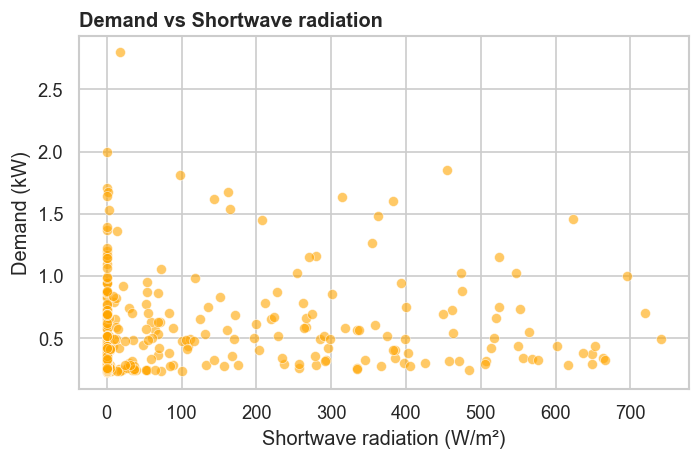

In [6]:
# Visualize Demand vs Shortwave Radiation
irr_sample = subset.sample(2000, random_state=21)
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=irr_sample, x='Shortwave_radiation (W/m²)', y='Demand', color=COLORS['irradiance'], alpha=0.6, ax=ax)
ax.set_title('Demand vs Shortwave radiation')
ax.set_xlabel('Shortwave radiation (W/m²)')
ax.set_ylabel('Demand (kW)')
fig.tight_layout()
save_figure(fig, 'task5_fig_demand_vs_shortwave')
plt.show()

fig_px = px.scatter(irr_sample, x='Shortwave_radiation (W/m²)', y='Demand', opacity=0.6,
                    labels={'Shortwave_radiation (W/m²)': 'Shortwave radiation (W/m²)', 'Demand': 'Demand (kW)'},
                    title='Demand vs Shortwave radiation')
save_interactive(fig_px, 'task5_fig_demand_vs_shortwave_interactive')
fig_px.show()

## Distribution analysis and transformations

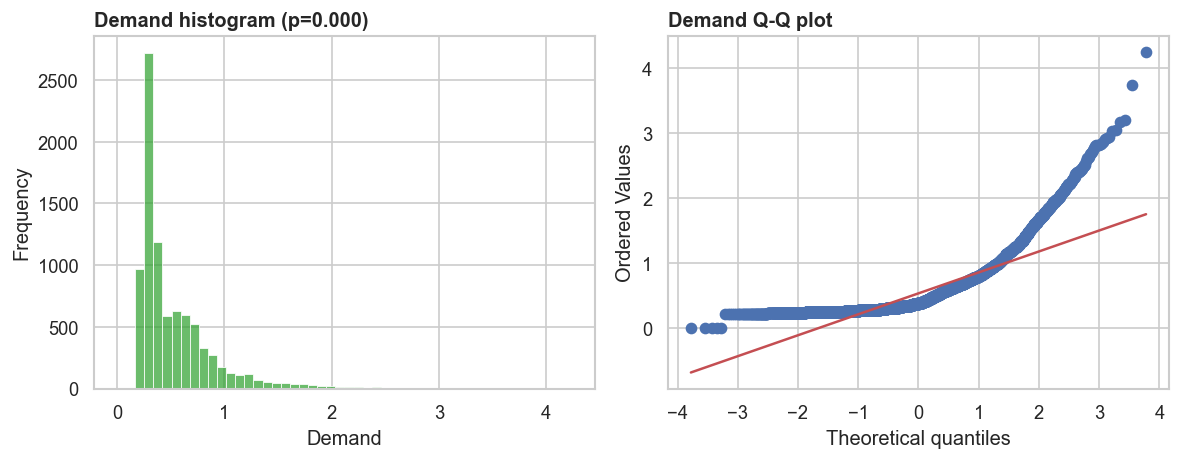

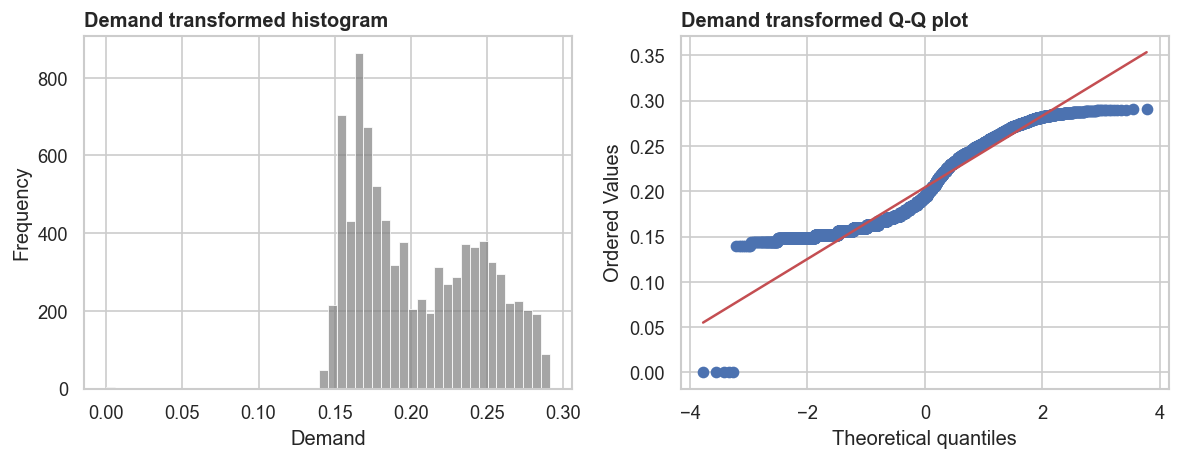

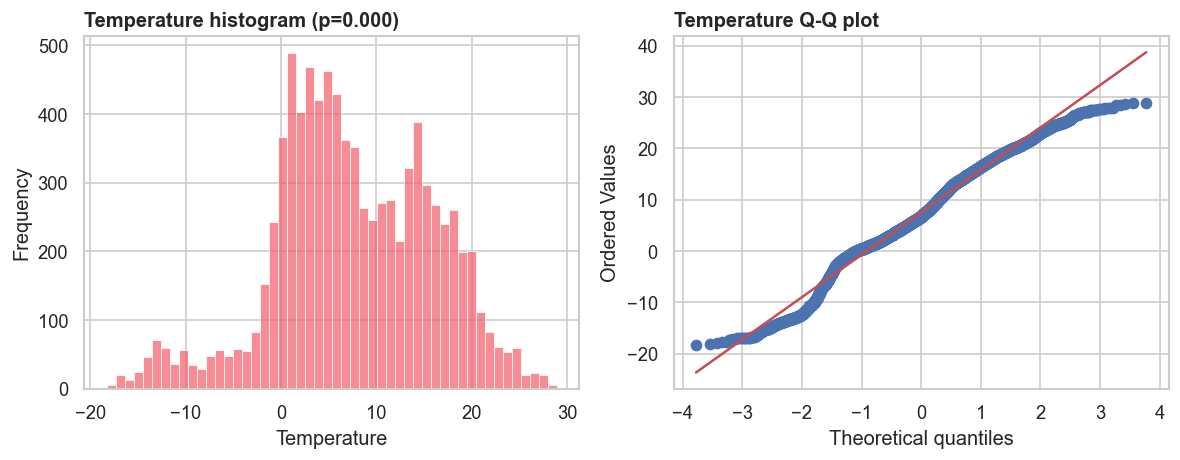

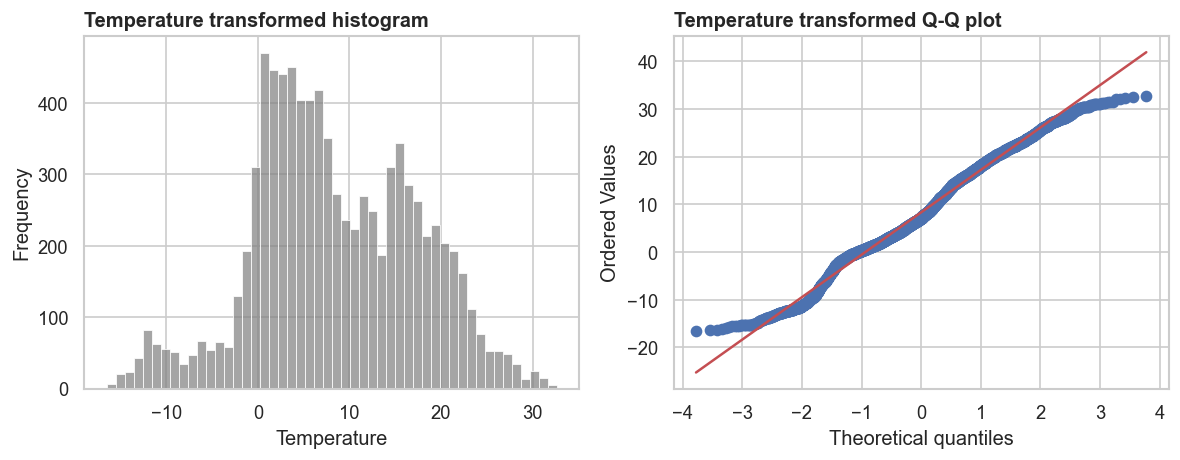

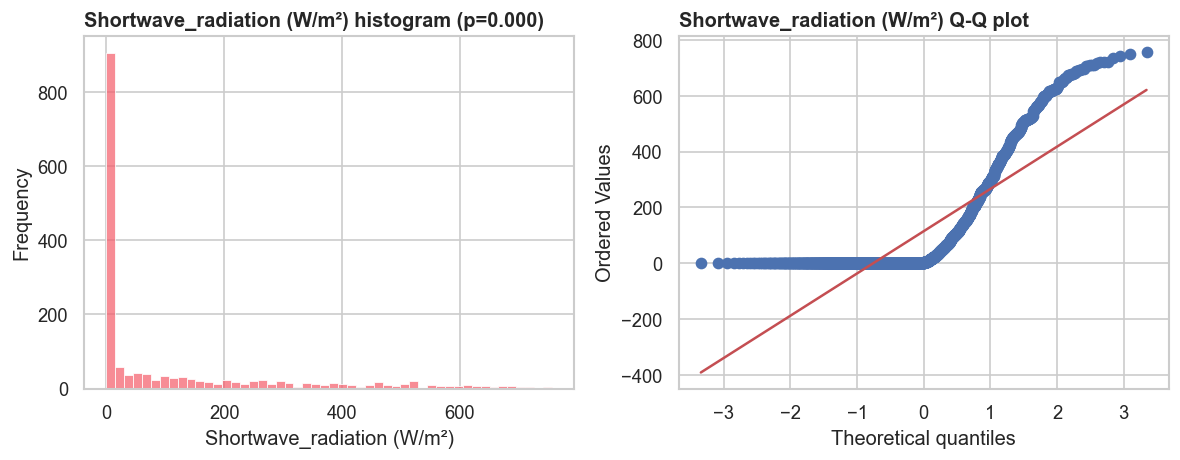

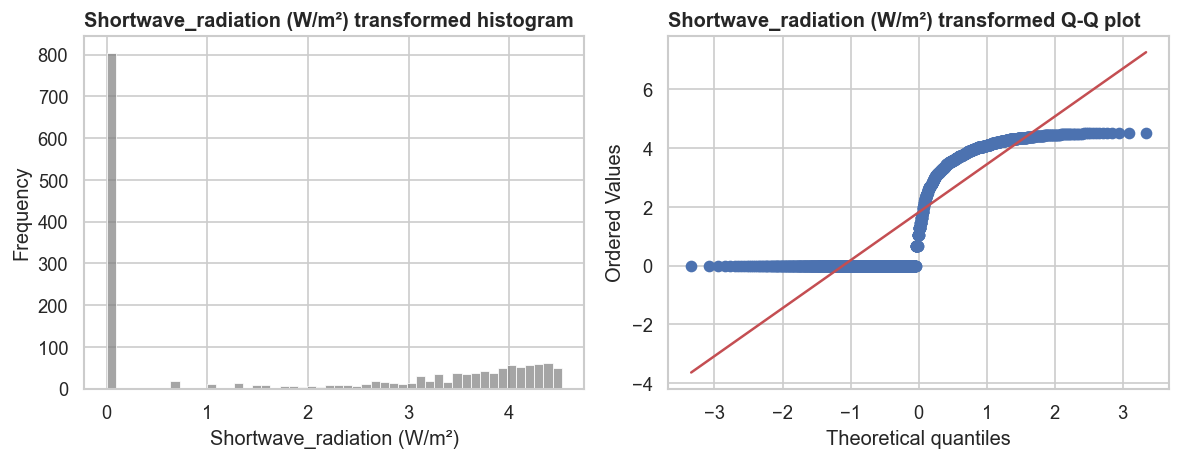

In [7]:
# Analyze distributions and apply transformations
transformer = PowerTransformer(method='yeo-johnson', standardize=False)
analysis_vars = ['Demand', 'Temperature', 'Shortwave_radiation (W/m²)']

for var in analysis_vars:
    series = subset[var].dropna()
    sample = series.sample(min(5000, len(series)), random_state=42)
    stat, pvalue = stats.shapiro(sample)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(series, bins=50, color=COLORS['demand'] if var == 'Demand' else COLORS['temperature'], alpha=0.7, ax=axes[0])
    axes[0].set_title(f'{var} histogram (p={pvalue:.3f})')
    axes[0].set_xlabel(var)
    axes[0].set_ylabel('Frequency')
    stats.probplot(series, dist='norm', plot=axes[1])
    axes[1].set_title(f'{var} Q-Q plot')
    fig.tight_layout()
    base = f'task5_fig_{var.replace(" ", "_").replace("/", "_")}_dist'
    save_figure(fig, base)
    plt.show()

    if pvalue < 0.05:
        transformed = transformer.fit_transform(series.values.reshape(-1, 1)).flatten()
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        sns.histplot(transformed, bins=50, color=COLORS['engineered'], alpha=0.7, ax=axes[0])
        axes[0].set_title(f'{var} transformed histogram')
        axes[0].set_xlabel(var)
        axes[0].set_ylabel('Frequency')
        stats.probplot(transformed, dist='norm', plot=axes[1])
        axes[1].set_title(f'{var} transformed Q-Q plot')
        fig.tight_layout()
        base_t = f'task5_fig_{var.replace(" ", "_").replace("/", "_")}_transformed'
        save_figure(fig, base_t)
        plt.show()

## Feature engineering

In [8]:
# Create engineered features
features = df.copy()
features['hour'] = features.index.hour
features['dayofweek'] = features.index.dayofweek
features['is_weekend'] = (features['dayofweek'] >= 5).astype(int)
features['hour_sin'] = np.sin(2 * np.pi * features['hour'] / 24)
features['hour_cos'] = np.cos(2 * np.pi * features['hour'] / 24)
features['cooling_degree'] = np.clip(features['Temperature'] - 18, 0, None)
features['heating_degree'] = np.clip(18 - features['Temperature'], 0, None)
features['temp_irradiance_interaction'] = features['Temperature'] * features['Shortwave_radiation (W/m²)']
selected_cols = ['Demand', 'hour_sin', 'hour_cos', 'is_weekend', 'cooling_degree', 'heating_degree',
                 'temp_irradiance_interaction'] + weather_cols
processed_path = PROCESSED_PATH / 'task5_features.parquet'
features[selected_cols].to_parquet(processed_path)

print("Engineered Features (Head):")
display(features[selected_cols].head())

Engineered Features (Head):


,Demand,hour_sin,hour_cos,is_weekend,cooling_degree,heating_degree,temp_irradiance_interaction,Temperature,Pressure (hPa),Cloud_cover (%),Wind_speed_10m (km/h),Shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),Price
timestamp,,,,,,,,,,,,,,,,
2013-07-01 00:00:00+00:00,0.27,0.000000,1.000000,0,0.0,4.5,NaN,13.5,1011.3,4,10.5,NaN,0,0,0.0,0.01605
2013-07-01 01:00:00+00:00,0.23,0.258819,0.965926,0,0.0,4.8,NaN,13.2,1010.8,27,11.9,NaN,0,0,0.0,0.00095
2013-07-01 02:00:00+00:00,0.26,0.500000,0.866025,0,0.0,4.9,NaN,13.1,1010.3,33,11.6,NaN,0,0,0.0,0.00060
2013-07-01 03:00:00+00:00,0.28,0.707107,0.707107,0,0.0,5.0,NaN,13.0,1010.3,28,11.2,NaN,2,7,30.1,0.00046
2013-07-01 04:00:00+00:00,0.29,0.866025,0.500000,0,0.0,4.2,NaN,13.8,1010.2,16,11.7,NaN,30,31,252.0,0.00046


## Feature ranking

In [9]:
# Rank features using Mutual Information and Random Forest
clean = features[selected_cols].dropna()
sample = clean.sample(min(1000, len(clean)), random_state=42)
X = sample.drop(columns=['Demand'])
y = sample['Demand']

mi_scores = mutual_info_regression(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns, name='mutual_information').sort_values(ascending=False)
mi_series.round(4).to_csv(TABLES_DIR / 'task5_feature_ranking_mi.csv')

rf = RandomForestRegressor(n_estimators=80, random_state=42, n_jobs=-1)
rf.fit(X, y)
perm_scores = permutation_importance(rf, X, y, n_repeats=3, random_state=42, n_jobs=-1)
perm_series = pd.Series(perm_scores.importances_mean, index=X.columns, name='permutation').sort_values(ascending=False)
perm_series.round(4).to_csv(TABLES_DIR / 'task5_feature_ranking_permutation.csv')
combined = pd.concat([mi_series, perm_series], axis=1)
combined.to_csv(TABLES_DIR / 'task5_feature_ranking_combined.csv')

print("Feature Ranking:")
display(combined.head())

Feature Ranking:


,mutual_information,permutation
hour_cos,0.133851,0.293501
hour_sin,0.109495,0.515502
heating_degree,0.089476,0.161763
Temperature,0.081546,0.132669
Cloud_cover (%),0.067358,0.097224


### Figure 4 – Top features (mutual information)

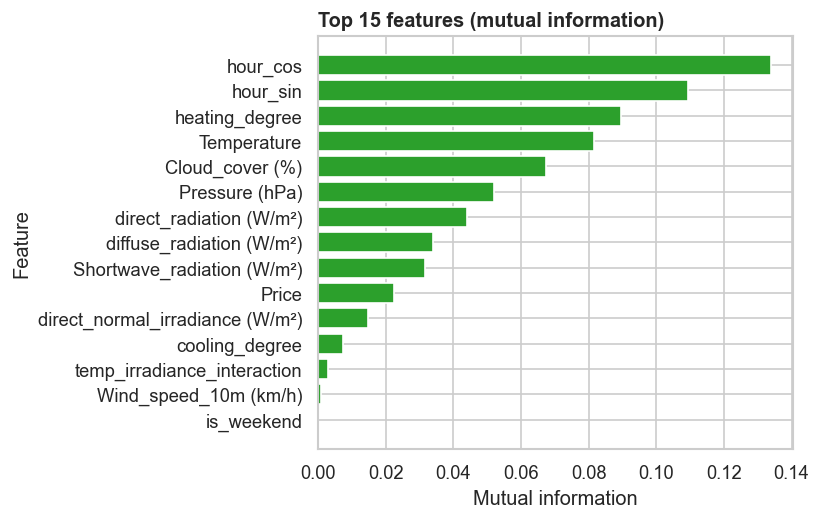

In [10]:
# Visualize Top 15 Features
top15 = mi_series.head(15)
fig, ax = plt.subplots(figsize=(7, 4.5))
ax.barh(top15.index[::-1], top15.values[::-1], color=COLORS['demand'])
ax.set_title('Top 15 features (mutual information)')
ax.set_xlabel('Mutual information')
ax.set_ylabel('Feature')
fig.tight_layout()
save_figure(fig, 'task5_fig_feature_ranking_mi')
plt.show()

fig_px = px.bar(x=top15.values, y=top15.index, orientation='h',
               labels={'x': 'Mutual information', 'y': 'Feature'},
               title='Top 15 features (mutual information)')
save_interactive(fig_px, 'task5_fig_feature_ranking_mi_interactive')
fig_px.show()

## Discussion
Time-of-day encodings (`hour_sin`, `hour_cos`) and the weekend indicator dominate the rankings, which is
expected for residential load shaped by daily and weekly routines. Weather-driven variables (temperature,
irradiance, and their interaction) also score highly, highlighting the influence of HVAC usage and solar
production on demand. Engineered signals that rank lower likely add limited new information beyond the
base weather variables or suffer from noise; they can be refined in later iterations.